In [1]:
import torch
import torchvision
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
device = torch.device('cuda')
# device = torch.device('cpu')

In [3]:
# Function to load dataset
def load_data_CIFAR10(batch_size, resize=None):
    trans = [torchvision.transforms.ToTensor()]
    if resize:
        trans.insert(0, torchvision.transforms.Resize(resize))
    trans = torchvision.transforms.Compose(trans)
    cifar10_train = torchvision.datasets.CIFAR10(
        root="./data", train=True, transform=trans, download=True)
    cifar10_test = torchvision.datasets.CIFAR10(
        root="./data", train=False, transform=trans, download=True)
    return (torch.utils.data.DataLoader(cifar10_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(cifar10_test, batch_size, shuffle=False,
                            num_workers=2))

In [4]:
# Set batch size and load training and test split into variables 
batch_size = 128
train_iter, test_iter = load_data_CIFAR10(batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Show shape of features matrix and target vector
X,y = next(iter(train_iter))
print(X.shape)
print(y.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128])


In [7]:
class convlblock(torch.nn.Module):
    def __init__(self, input_channels, output_channels, num_convs):
        super(convlblock, self).__init__()
        self.num_convs = num_convs
        self.conv_blocks = torch.nn.ModuleList()

        # Stack of conv-batchnorm-relu blocks
        for _ in range(num_convs):
            block = torch.nn.Sequential(
                torch.nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
                torch.nn.BatchNorm2d(output_channels),  # Normalize activations
                torch.nn.ReLU()  # Add non-linearity
            )
            self.conv_blocks.append(block)
            input_channels = output_channels  # Next block gets same number of channels

        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)  # Reduce spatial dimensions
        self.fc = torch.nn.Linear(output_channels, num_convs)  # Learns mixing weights

    def forward(self, x):
        conv_outputs = []
        current_input = x

        # Process through all conv blocks
        for block in self.conv_blocks:
            current_input = block(current_input)
            conv_outputs.append(current_input)  # Save each output

        pooled = self.pool(current_input)  # Downsample
        avg_channel_values = pooled.mean(dim=(2, 3))  # Global average pooling
        a = self.fc(avg_channel_values)  # Get mixing coefficients

        # Combine all conv outputs using learned weights
        combined = sum(
            a[:, i].view(-1, 1, 1, 1) * conv_outputs[i]
            for i in range(self.num_convs)
        )
        return combined


class Net(torch.nn.Module):
    def __init__(self, conv_arch, num_outputs):
        super(Net, self).__init__()
        self.num_outputs = num_outputs
        modules = []
        input_channels = 3  # RGB input

        # Build convolutional backbone
        for num_convs, output_channels in conv_arch:
            modules.append(convlblock(input_channels, output_channels, num_convs))
            input_channels = output_channels
        
        self.convlblocks = torch.nn.Sequential(*modules)
        
        # Classification head
        self.maxpool = torch.nn.AdaptiveMaxPool2d(1)  # Global pooling
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(input_channels, 128)
        self.rl1 = torch.nn.ReLU()
        self.drop1 = torch.nn.Dropout()  # Regularization
        self.fc2 = torch.nn.Linear(128, num_outputs)
        
        # Initialize biases to zero
        torch.nn.init.zeros_(self.fc1.bias)
        torch.nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        # Feature extraction
        x = self.convlblocks(x)
        
        # Classification
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.rl1(x)
        x = self.drop1(x)
        x = self.fc2(x)
        return x

In [8]:
# Applies Xavier initialization if the `torch.nn.Module` is `torch.nn.Linear` or `torch.nn.Conv2d`
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        (torch.nn.init.xavier_uniform_(m.weight))

# Define number of output classes (e.g., for 10-class classification)
num_outputs = 10

# Convolutional architecture: 
# Example: [(2,32)] means 2 conv layers with 32 output channels
conv_arch = [(2,32), (2, 64), (3,128), (3, 128), (2,128)]

# Initialize model and move to GPU if available
model = Net(conv_arch, num_outputs).to(device) 

# Apply custom weight initialization to all layers
model.apply(init_weights)  

Net(
  (convlblocks): Sequential(
    (0): convlblock(
      (conv_blocks): ModuleList(
        (0): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (1): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (fc): Linear(in_features=32, out_features=2, bias=True)
    )
    (1): convlblock(
      (conv_blocks): ModuleList(
        (0): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
     

In [9]:
# Define cross-entropy loss for classification tasks
loss = torch.nn.CrossEntropyLoss()

# Set initial learning rate
lr = 0.001

# Initialize Adam optimizer with model parameters and learning rate
optimiser = torch.optim.Adam(model.parameters(), lr=lr)

# Configure learning rate scheduler to reduce LR by half every 20 epochs
scheduler = StepLR(optimiser, step_size=20, gamma=0.5)

In [10]:
# Function for Classification
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

In [11]:
def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = 0.
    n = 0.
    for X, y in data_iter:
      X, y = X.to(device), y.to(device) # Moves data to `device`
      logits = model(X)
      c += metric(logits, y)
      n += len(y)

    return float(c / n)

In [12]:
model.eval() # This is necessary because Dropout behaves differently between training and evaluation
print(f'Training accuracy: {evaluate_metric(model, train_iter, correct)}. Testing accuracy: {evaluate_metric(model, test_iter, correct)}.')

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Training accuracy: 0.09999999403953552. Testing accuracy: 0.09999999403953552.



Epoch 1/50, LR: 0.001000
Training accuracy: 0.10446000099182129. Testing accuracy: 0.10579999536275864. Duration: 40.768s.

Epoch 2/50, LR: 0.001000
Training accuracy: 0.10424000024795532. Testing accuracy: 0.10480000078678131. Duration: 40.357s.

Epoch 3/50, LR: 0.001000
Training accuracy: 0.10551999509334564. Testing accuracy: 0.1062999963760376. Duration: 40.207s.

Epoch 4/50, LR: 0.001000
Training accuracy: 0.10653999447822571. Testing accuracy: 0.10819999873638153. Duration: 40.289s.

Epoch 5/50, LR: 0.001000
Training accuracy: 0.1285800039768219. Testing accuracy: 0.13249999284744263. Duration: 40.117s.

Epoch 6/50, LR: 0.001000
Training accuracy: 0.2552199959754944. Testing accuracy: 0.2587999999523163. Duration: 40.438s.

Epoch 7/50, LR: 0.001000
Training accuracy: 0.3075999915599823. Testing accuracy: 0.3105999827384949. Duration: 40.134s.

Epoch 8/50, LR: 0.001000
Training accuracy: 0.3329799771308899. Testing accuracy: 0.3342999815940857. Duration: 40.220s.

Epoch 9/50, LR:

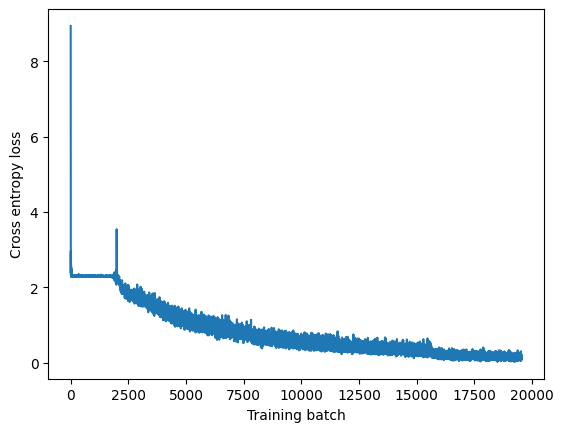

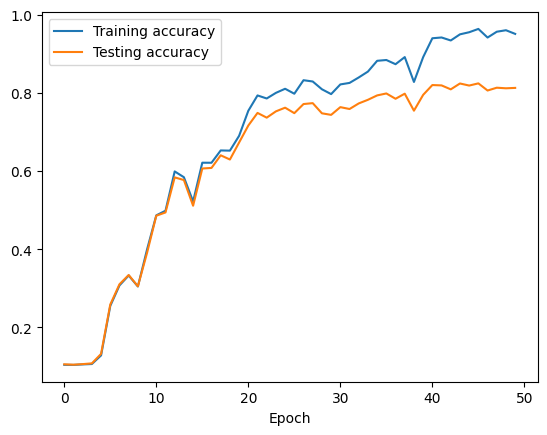

In [13]:
# Initialize lists to track training progress
losses = [] # Stores loss values for each batch
train_accs = [] # Records training accuracy per epoch
test_accs = [] # Records validation accuracy per epoch
num_epochs = 50 # Total training epochs

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}, LR: {scheduler.get_last_lr()[0]:.6f}')
    start_time = time.perf_counter()

# Training phase
    model.train()
    for X, y in train_iter:
        X, y = X.to(device), y.to(device) # Move data to device (GPU/CPU)
        logits = model(X) # Forward pass
        l = loss(logits, y) # Compute loss
        optimiser.zero_grad() # Clear previous gradients
        l.backward() # Backpropagation
        optimiser.step() # Update weights
        losses.append(float(l)) # Store batch loss

    # Update LR after epoch 20 (will take effect at the start of epoch 21)
    scheduler.step()

    # Validation
    with torch.no_grad():
        model.eval() # Set model to evaluation mode
        train_accs.append(evaluate_metric(model, train_iter, correct)) # Train accuracy
        test_accs.append(evaluate_metric(model, test_iter, correct)) # Test accuracy
        end_time = time.perf_counter()
        print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}. Duration: {end_time - start_time:.3f}s.')

# Plot results
plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()